# Exploration of phonetic embeddings

In this notebook we will try to visualize embeddings of IPA characters and interpret them.
Our phonetic encoding model works at character level. It has learned a different embedding for each IPA character during its training.
We expect embedding of close such as in the IPA graph: 

![IPA Graph](https://d3uxfe7dw0hhy7.cloudfront.net/acip/assets/course/ipachart/IPA2005.png) 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mlflow
import torch
from src.pairing.model.phonetic_siamese import PhoneticSiamese
from pathlib import Path

import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Load model from MLFlow experiment

Load a model from MLFlow's artifacts.

In [3]:
# model_uri = "C:/Users/simon/Projets/FindingMnemo/mlruns/449760764592553836/eb14dcd397814042aef965683bb7b198/artifacts/model" # mlflow.artifacts.download_artifacts("")
# model = mlflow.pytorch.load_model(model_uri)
# model.eval()

Load the current model.

In [4]:
path = Path("../src/pairing/model/model_dict") 

def load_model(path) -> PhoneticSiamese:
    model = PhoneticSiamese()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

model = load_model(path)
cuda_device = torch.device('cuda:0')
cpu_device = torch.device('cpu')
model = model.to(cpu_device)

Get embeddings stored in the model and vocabulary associated with each row.

In [5]:
vocabulary = model.vocabulary
embedding = model.embedding.weight.detach().numpy()

## Visualization of embeddings using UMAP

*"UMAP is a general purpose manifold learning and dimension reduction algorithm."*
We use it in order to keep distances from large dimensions similar while reducing them to 2 dimension so that we can plot them on a graph.

### IPA character visualization

In this section, we try to visualize character based on their learned embeddings.

In [6]:
reducer = umap.UMAP()
scaled_embedding = StandardScaler().fit_transform(embedding)
umapped_embedding = reducer.fit_transform(scaled_embedding)
umapped_embedding.shape

(588, 2)

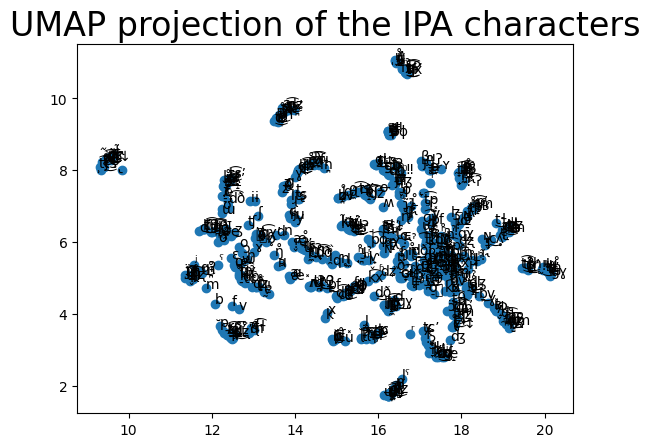

In [7]:
z = umapped_embedding[:, 0]
y = umapped_embedding[:, 1]
d = {x: y for y,x in vocabulary.items()}
fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(range(len(z)-1)):
    ax.annotate(d[i], (z[i], y[i]))

plt.title('UMAP projection of the IPA characters', fontsize=24)
plt.show()

### Word visualization

In this section we will visualize complete words after being encoded by the model.

In [8]:
import pandas as pd
import numpy as np
chinese_df = pd.read_csv('../src/pairing/dataset/pairing/chinese.csv')
english_df = pd.read_csv('../src/pairing/dataset/pairing/english.csv')

In [9]:
sample_chinese_df = chinese_df.sample(1000)
sample_english_df = english_df.sample(1000)

In [10]:
chinese_phonetics = sample_chinese_df['ipa'].dropna()
english_phonetics = sample_english_df['ipa'].dropna()

In [11]:
model = model.to(cuda_device)

In [12]:
chinese_embeddings = model.encode(chinese_phonetics.values).to(cpu_device).detach().numpy()
english_embeddings = model.encode(english_phonetics.values).to(cpu_device).detach().numpy()
all_embeddings = np.concatenate((chinese_embeddings, english_embeddings), axis=0)
language = ['red']*len(chinese_embeddings) + ['blue']*len(english_embeddings)
word_len = [len(w) for w in chinese_phonetics] + [len(w) for w in english_phonetics]

In [13]:
reducer = umap.UMAP()
scaled_embedding = StandardScaler().fit_transform(all_embeddings)
umapped_embedding = reducer.fit_transform(scaled_embedding)
umapped_embedding.shape

(2000, 2)

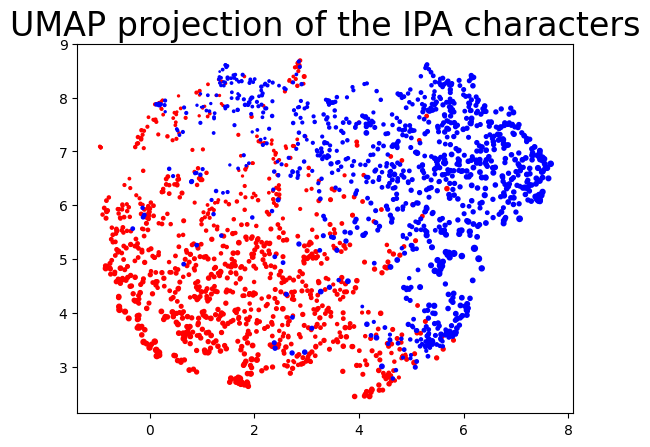

In [14]:
z = umapped_embedding[:, 0]
y = umapped_embedding[:, 1]
fig, ax = plt.subplots()
ax.scatter(z, y, c=language, s=word_len)

plt.title('UMAP projection of the IPA characters', fontsize=24)
plt.show()